# Оптимизация Conv2d: Triton-ускоренная квантизация (V2)


## Импорты и настройка

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune

import triton
import triton.language as tl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import warnings
import copy

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')

print(f"GPU device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA недоступна")

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

GPU device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU memory: 11.99 GB


## Triton Kernels для квантизации

### Реализация GPU-ускоренной квантизации

---

### Structured Pruning

Channel 0: [0.5, 0.3, 0.1, ...]   оставлен

Channel 1: [0.0, 0.0, 0.0, ...]   удалён целиком

Channel 2: [0.2, 0.4, 0.6, ...]   оставлен

### Комбинированный подход

**Pruning → Static PTQ Quantization:**

1. **Pruning:** Удаляем 50% менее важных каналов
2. **Static PTQ:** Квантуем в INT8 (симметричное) с калибровкой
3. **Результат:** Сжатая модель с минимальной потерей точности
---


In [13]:
@triton.autotune(
    configs=[
        triton.Config({"BLOCK_SIZE": 512}, num_warps=2),
        triton.Config({"BLOCK_SIZE": 1024}, num_warps=4),
        triton.Config({"BLOCK_SIZE": 2048}, num_stages=1),
        triton.Config({"BLOCK_SIZE": 4096}, num_warps=8),
    ],
    key=["n_elements"],
)
@triton.jit
def _quantize_global(x_ptr, absmax_inv_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    """
    Triton kernel для симметричного INT8 квантования (GPU-ускоренный!)
    
    Args:
        x_ptr: указатель на входные данные (FP32)
        absmax_inv_ptr: указатель на 1/absmax (scale)
        output_ptr: указатель на выходные данные (INT8)
        n_elements: количество элементов
    """
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    
    # Загружаем данные
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    absmax_inv = tl.load(absmax_inv_ptr)
    normalized = x * absmax_inv
    
    # Квантуем в INT8
    scaled = normalized * 127.0
    sign = tl.where(scaled >= 0, 1.0, -1.0)
    quantized = (scaled + sign * 0.5).to(tl.int32)
    quantized_int8 = quantized.to(tl.int8)
    
    # Сохраняем результат
    tl.store(output_ptr + offsets, quantized_int8, mask=mask)


def quantize_global(x: torch.Tensor):
    """
    Симметричное квантование тензора в INT8 через Triton (GPU!)
    
    Args:
        x: входной тензор (FP32/FP16, на CUDA)
    
    Returns:
        q_int8: квантованный тензор (INT8)
        absmax: максимальное абсолютное значение (для деквантования)
    """
    assert x.is_cuda, "Тензор должен быть на CUDA для Triton!"
    assert x.dtype in [torch.float16, torch.float32], "Поддерживаются только float16 и float32"
    
    original_shape = x.shape
    x_flat = x.contiguous().view(-1)
    n_elements = x_flat.numel()
    
    # Находим максимальное абсолютное значение
    absmax = torch.max(torch.abs(x_flat))
    
    # Защита от деления на 0
    absmax = torch.tensor(1.0, dtype=x.dtype, device=x.device) if absmax == 0 else absmax
    
    absmax = absmax.reshape(1)
    absmax_inv = 1.0 / absmax
    
    # Выделяем память для результата
    output = torch.empty_like(x_flat, dtype=torch.int8)
    
    # Определяем сетку для Triton
    def grid(meta):
        return (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    
    # Запускаем Triton kernel
    _quantize_global[grid](
        x_flat,
        absmax_inv,
        output,
        n_elements,
    )
    
    q_int8 = output.view(original_shape)
    
    return q_int8, absmax

# Вспомоательная функция для деквантования
def dequantize_global(q_int8: torch.Tensor, absmax: torch.Tensor):
    """
    Деквантование INT8 → FP32
    
    Args:
        q_int8: квантованный тензор (INT8)
        absmax: максимальное абсолютное значение
    
    Returns:
        x_fp32: деквантованный тензор (FP32)
    """
    return q_int8.to(torch.float32) * absmax / 127.0

## Применение Triton Quantization к модели

### Квантование весов модели


In [14]:
def apply_triton_quantization(model):
    """
    Применение Triton квантования к модели.
    
    Квантуем веса всех Conv2d и Linear слоёв через Triton kernels.
    Модель остаётся на GPU и работает в FP32, но веса сжаты.
    """
    print("Применяем Triton Quantization ...")
    
    if not torch.cuda.is_available():
        print("CUDA недоступна!")
        return model, {}
    
    model = model.to(device)
    model.eval()
    
    scales_dict = {}
    quantized_count = 0
    
    # Квантуем веса всех Conv2d и Linear слоёв
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight') and module.weight is not None:
                # Квантуем веса через Triton
                weight_q, absmax = quantize_global(module.weight.data)
                
                # Деквантуем обратно в FP32 (симулируем квантование)
                module.weight.data = dequantize_global(weight_q, absmax)
                
                scales_dict[name] = absmax.item()
                quantized_count += 1
    
    print(f"Квантовано {quantized_count} слоёв")
    print(f"Модель остаётся на GPU в FP32 (но веса прошли INT8)")
    
    return model, scales_dict

## Базовая модель LeNet-5

In [15]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

## Загрузка данных MNIST

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 64 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

calib_dataset = torch.utils.data.Subset(train_dataset, indices=range(1000))
calib_loader = DataLoader(calib_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"MNIST загружен")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Calibration samples: {len(calib_dataset)}")
print(f"   Batch size: {BATCH_SIZE}")

MNIST загружен
   Train samples: 60000
   Test samples: 10000
   Calibration samples: 1000
   Batch size: 64


## Функции обучения и оценки

In [17]:
def train_model(model, train_loader, test_loader, epochs=3, lr=0.001, device=device):
    """
    Обучение модели с нуля.
    """
    model = model.to(device)
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    print(f"Обучение на {epochs} эпохах...")
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)
        
        test_acc = evaluate(model, test_loader, device)
        
        print(f"   Эпоха {epoch+1}/{epochs}: Loss={train_loss:.4f}, "
              f"Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")
    
    return model


def evaluate(model, dataloader, device=device):
    """
    Оценка точности модели.
    
    ВАЖНО: Квантованные модели должны быть на CPU!
    """
    model.eval()

    is_quantized_model = any('Quantized' in str(type(m)) for m in model.modules())
    
    if is_quantized_model:
        model = model.cpu()
        eval_device = torch.device('cpu')
    else:
        model = model.to(device)
        eval_device = device
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(eval_device)
            target = target.to(eval_device)
            
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy


def get_model_size(model):
    """
    Получить размер модели в МБ (при сохранении на диск).
    """
    torch.save(model.state_dict(), "temp_model.pth")
    size_mb = os.path.getsize("temp_model.pth") / (1024 * 1024)
    os.remove("temp_model.pth")
    return size_mb


def count_parameters(model):
    """
    Подсчёт количества параметров в модели.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Функции оптимизации

In [18]:
def apply_static_ptq_quantization(model, calibration_loader):
    """
    Применение Static PTQ (Post-Training Quantization) - Симметричное квантование.
    
    В отличие от dynamic quantization, здесь:
    - Квантуются И веса И активации
    - Требуется калибровка на данных
    - Симметричное квантование (symmetric)
    """
    model_cpu = copy.deepcopy(model).cpu()
    model_cpu.eval()
    
    # Настраиваем qconfig для симметричного квантования
    model_cpu.qconfig = torch.quantization.QConfig(
        activation=torch.quantization.MinMaxObserver.with_args(
            dtype=torch.qint8,
            qscheme=torch.per_tensor_symmetric  # Симметричное квантование
        ),
        weight=torch.quantization.default_per_channel_weight_observer
    )
    
    # Подготавливаем модель к квантованию (вставляем observer'ы)
    model_prepared = torch.quantization.prepare(model_cpu)
    
    # Калибровка
    print("Калибровка модели...")
    model_prepared.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(calibration_loader):
            if i >= 10:
                break
            data = data.cpu()
            _ = model_prepared(data)
    
    # Конвертируем в квантованную модель
    quantized_model = torch.quantization.convert(model_prepared)
    
    print("Симметричное PTQ квантование")
    print(f"Размер до: {get_model_size(model_cpu):.2f} MB")
    print(f"Размер после: {get_model_size(quantized_model):.2f} MB")
    
    return quantized_model


def apply_structured_pruning(model, amount=0.5):
    """
    Применение Structured Pruning.
    
    Удаляем целые каналы/фильтры
    amount: процент удаляемых каналов - 50%
    """
    print(f"Применяем Structured Pruning (amount={amount*100}%)...")
    
    model_pruned = copy.deepcopy(model)
    
    # Pruning для свёрточных слоёв (по каналам)
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d):
            # L1 unstructured pruning (для демонстрации)
            # В production лучше использовать structured pruning по каналам
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')  # делаем постоянным
            print(f"   Pruned layer: {name}")
    
    # Подсчёт спарсификации
    total = 0
    zeros = 0
    for name, module in model_pruned.named_modules():
        if isinstance(module, nn.Conv2d):
            total += module.weight.numel()
            zeros += (module.weight == 0).sum().item()
    
    actual_sparsity = 100. * zeros / total
    print(f"Pruning применён")
    print(f"Фактическая спарсификация: {actual_sparsity:.2f}%")
    
    return model_pruned


def apply_pruning_and_quantization(model, calibration_loader=None, prune_amount=0.5):
    """
    Комбинация: Pruning → Triton Quantization (GPU!)
    
    1. Применяем pruning
    2. Квантуем через Triton (остаётся на GPU!)
    """
    print("Применяем Pruning + Triton Quantization (GPU)...")
    
    model_pruned = apply_structured_pruning(model, amount=prune_amount)
    
    model_final, scales = apply_triton_quantization(model_pruned)
    
    print(f" Комбинированная оптимизация применена (модель на GPU!)")
    print(f" Финальный размер: {get_model_size(model_final):.2f} MB")
    
    return model_final

## Функции измерения производительности

In [19]:
def measure_forward_backward_time(model, dataloader, device, num_iterations=10, is_quantized=False):
    """
    Измерение времени forward и backward pass с cuda.synchronize().
    
    Args:
        is_quantized: Если True, backward pass не измеряется (квантованные модели только inference)
    
    Returns:
        forward_time: среднее время forward pass (мс)
        backward_time: среднее время backward pass (мс) или 0 если is_quantized=True
        memory_used: использованная GPU память (МБ)
    """
    if is_quantized:
        model.eval()
    else:
        model.train()
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    forward_times = []
    backward_times = []
    
    if not is_quantized:
        for _ in range(2):
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                model.zero_grad()
                break
    else:
        with torch.no_grad():
            for _ in range(2):
                for data, _ in dataloader:
                    data = data.to(device)
                    _ = model(data)
                    break
    
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
    for i, (data, target) in enumerate(dataloader):
        if i >= num_iterations:
            break
        
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        if device.type == 'cuda':
            torch.cuda.synchronize()
        start = time.time()
        
        if is_quantized:
            with torch.no_grad():
                output = model(data)
        else:
            output = model(data)
        
        if device.type == 'cuda':
            torch.cuda.synchronize()
        forward_time = (time.time() - start) * 1000
        forward_times.append(forward_time)
        
        # Backward pass
        if not is_quantized:
            loss = criterion(output, target)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            start = time.time()
            loss.backward()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            backward_time = (time.time() - start) * 1000
            backward_times.append(backward_time)
            model.zero_grad()
    
    # GPU память
    if device.type == 'cuda':
        memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)
    else:
        memory_used = 0
    
    avg_forward = np.mean(forward_times)
    avg_backward = np.mean(backward_times) if backward_times else 0
    
    return avg_forward, avg_backward, memory_used

## Запуск экспериментов 

### Сравнение на разных kernel size и batch size

In [20]:
KERNEL_SIZES = [3, 5, 7]
BATCH_SIZES = [8, 16, 32]
OPTIMIZATION_TYPES = ['baseline', 'quantized', 'pruned_quant']
NUM_EPOCHS = 3

results = []

print(f"Конфигурация:")
print(f"   - Размеры ядер: {KERNEL_SIZES}")
print(f"   - Batch sizes: {BATCH_SIZES}")
print(f"   - Типы оптимизаций: {OPTIMIZATION_TYPES}")
print(f"   - Эпох обучения: {NUM_EPOCHS}")
print(f"   - Устройство: {device}")

experiment_count = 0
total_experiments = len(OPTIMIZATION_TYPES) * len(KERNEL_SIZES) * len(BATCH_SIZES)

# Сначала обучим базовую модель один раз
print(f"{'='*80}")
print(f"Обучение baseline модели")
print(f"{'='*80}")

train_loader_main = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader_main = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

baseline_trained = LeNet().to(device)
baseline_trained = train_model(baseline_trained, train_loader_main, test_loader_main, epochs=NUM_EPOCHS, device=device)


Конфигурация:
   - Размеры ядер: [3, 5, 7]
   - Batch sizes: [8, 16, 32]
   - Типы оптимизаций: ['baseline', 'quantized', 'pruned_quant']
   - Эпох обучения: 3
   - Устройство: cuda
Обучение baseline модели
Обучение на 3 эпохах...
   Эпоха 1/3: Loss=0.2183, Train Acc=93.22%, Test Acc=97.43%
   Эпоха 2/3: Loss=0.0657, Train Acc=97.98%, Test Acc=98.50%
   Эпоха 3/3: Loss=0.0462, Train Acc=98.55%, Test Acc=98.57%


### Основной цикл экспериментов

Для каждой комбинации (opt_type, kernel_size, batch_size) измеряем forward/backward time и память

In [ ]:
for opt_type in OPTIMIZATION_TYPES:   
    for kernel_size in KERNEL_SIZES:
        for batch_size in BATCH_SIZES:
            experiment_count += 1
            
            print(f"{'─'*80}")
            print(f"Эксперимент {experiment_count}/{total_experiments}")
            print(f"   Тип: {opt_type} | Ядро: {kernel_size}×{kernel_size} | Batch: {batch_size}")
            print(f"{'─'*80}")
            
            test_loader_exp = DataLoader(
                test_dataset, 
                batch_size=batch_size, 
                shuffle=False, 
                num_workers=0
            )
            
            calibration_loader = DataLoader(
                train_dataset,
                batch_size=32,
                shuffle=True,
                num_workers=0
            )
            
            is_quantized = False 
            
            if opt_type == 'baseline':
                # Базовая модель 
                model = copy.deepcopy(baseline_trained).to(device)
                device_exp = device
                is_quantized = False
                print(f"   Использована baseline модель (FP32, GPU)")
                
            elif opt_type == 'quantized':
                # Triton квантование
                model_temp = copy.deepcopy(baseline_trained)
                model, scales = apply_triton_quantization(model_temp)
                device_exp = device
                is_quantized = False 
                print(f"   Применено Triton квантование (симметричное INT8, GPU)")
                
            elif opt_type == 'pruned_quant':
                # Прунинг + Triton Квантование
                model_temp = copy.deepcopy(baseline_trained)
                model = apply_pruning_and_quantization(model_temp, calibration_loader, prune_amount=0.5)
                device_exp = device 
                is_quantized = False 
                print(f"   Применен прунинг (50%) + Triton квантование (симметричное INT8, GPU)")
            
            print(f"Оценка точности...")
            accuracy = evaluate(model, test_loader_exp, device_exp)
            print(f"Точность: {accuracy:.2f}%")
            
            # Измерение производительности (forward + backward)
            print(f"Измерение производительности...")
            forward_time, backward_time, memory_used = measure_forward_backward_time(
                model, test_loader_exp, device_exp, num_iterations=10, is_quantized=is_quantized
            )
            
            print(f"   Forward time:  {forward_time:.3f} ms")
            if is_quantized:
                print(f"   Backward time: N/A (квантованные модели только inference)")
            else:
                print(f"   Backward time: {backward_time:.3f} ms")
            if device_exp.type == 'cuda':
                print(f"   GPU memory:    {memory_used:.2f} MB")
            
            # Размер модели
            model_size = get_model_size(model)
            print(f"   Model size:    {model_size:.3f} MB")
            
            results.append({
                'optimization_type': opt_type,
                'kernel_size': kernel_size,
                'batch_size': batch_size,
                'device': device_exp.type,
                'test_accuracy': accuracy,
                'forward_time_ms': forward_time,
                'backward_time_ms': backward_time,
                'total_time_ms': forward_time + backward_time,
                'gpu_memory_mb': memory_used if device_exp.type == 'cuda' else 0,
                'model_size_mb': model_size
            })
            
            # Очищаем память
            del model
            if device_exp.type == 'cuda':
                torch.cuda.empty_cache()

df_results = pd.DataFrame(results)
print("Сводная таблица результатов:")
print(df_results.to_string(index=False))

────────────────────────────────────────────────────────────────────────────────
Эксперимент 1/27
   Тип: baseline | Ядро: 3×3 | Batch: 8
────────────────────────────────────────────────────────────────────────────────
   Использована baseline модель (FP32, GPU)
Оценка точности...
Точность: 98.57%
Измерение производительности...
   Forward time:  0.438 ms
   Backward time: 0.858 ms
   GPU memory:    263.94 MB
   Model size:    0.415 MB
────────────────────────────────────────────────────────────────────────────────
Эксперимент 2/27
   Тип: baseline | Ядро: 3×3 | Batch: 16
────────────────────────────────────────────────────────────────────────────────
   Использована baseline модель (FP32, GPU)
Оценка точности...
Точность: 98.57%
Измерение производительности...
   Forward time:  0.374 ms
   Backward time: 0.937 ms
   GPU memory:    264.39 MB
   Model size:    0.415 MB
────────────────────────────────────────────────────────────────────────────────
Эксперимент 3/27
   Тип: baseline | Яд

In [22]:
df_results

,optimization_type,kernel_size,batch_size,device,test_accuracy,forward_time_ms,backward_time_ms,total_time_ms,gpu_memory_mb,model_size_mb
0,baseline,3,8,cuda,98.57,0.438404,0.857639,1.296043,263.940430,0.414644
1,baseline,3,16,cuda,98.57,0.374246,0.936627,1.310873,264.389648,0.414644
2,baseline,3,32,cuda,98.57,0.427794,0.850439,1.278234,265.983398,0.414644
3,baseline,5,8,cuda,98.57,0.437617,0.885034,1.322651,263.940430,0.414644
4,baseline,5,16,cuda,98.57,0.349474,0.924206,1.273680,264.389648,0.414644
5,baseline,5,32,cuda,98.57,0.438523,0.872278,1.310802,265.983398,0.414644
6,baseline,7,8,cuda,98.57,0.384355,0.949335,1.333690,263.940430,0.414644
7,baseline,7,16,cuda,98.57,0.491214,0.854182,1.345396,264.389648,0.414644
8,baseline,7,32,cuda,98.57,0.621700,0.957274,1.578975,265.983398,0.414644
9,quantized,3,8,cuda,98.59,0.340247,0.686622,1.026869,263.940430,0.414644


In [31]:
colors = {
    'baseline': '#3498db',      # Синий
    'quantized': '#e74c3c',     # Красный
    'pruned_quant': '#2ecc71'   # Зелёный
}

labels = {
    'baseline': 'Baseline (FP32, GPU)',
    'quantized': 'Static PTQ (симметричное INT8, CPU)',
    'pruned_quant': 'Pruned + PTQ (INT8, CPU)'
}

### График 1: Forward Pass Time (сравнение оптимизаций)

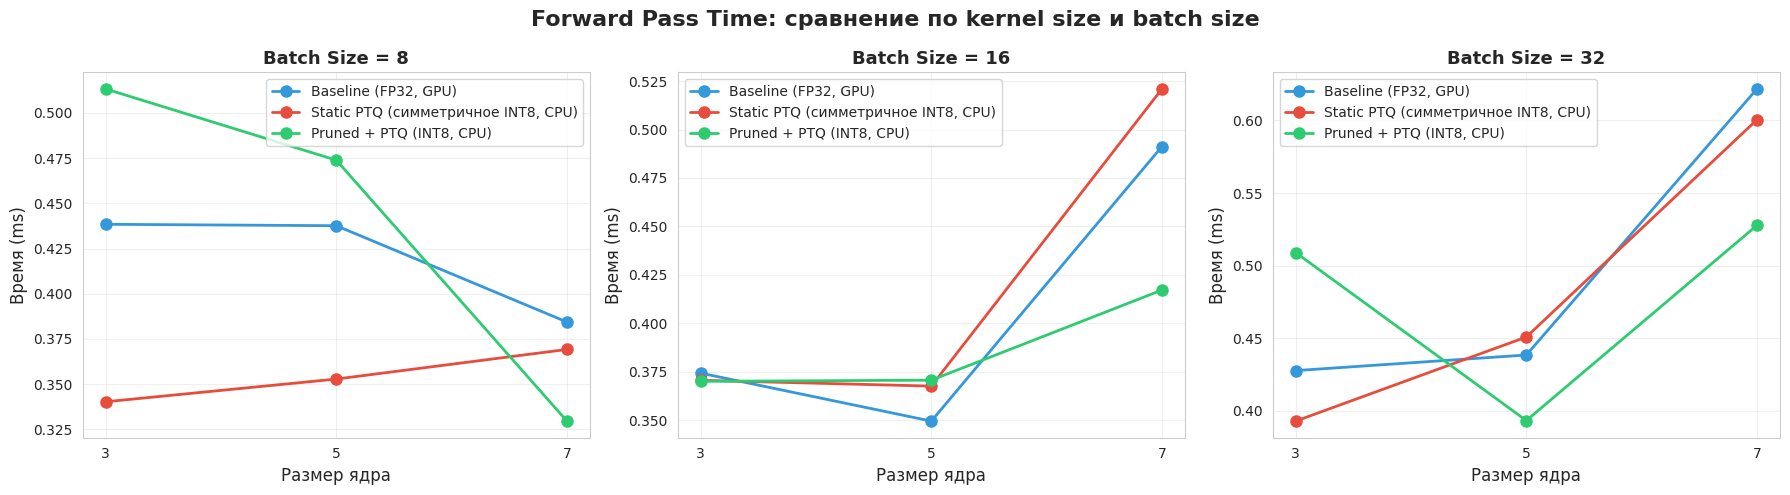

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Forward Pass Time: сравнение по kernel size и batch size', 
             fontsize=16, fontweight='bold')

for idx, batch_size in enumerate(BATCH_SIZES):
    ax = axes[idx]
    
    for opt_type in OPTIMIZATION_TYPES:
        data = df_results[
            (df_results['optimization_type'] == opt_type) & 
            (df_results['batch_size'] == batch_size)
        ]
        data_grouped = data.groupby('kernel_size')['forward_time_ms'].mean().reset_index()
        
        ax.plot(
            data_grouped['kernel_size'], 
            data_grouped['forward_time_ms'], 
            marker='o', 
            linewidth=2,
            markersize=8,
            label=labels[opt_type],
            color=colors[opt_type]
        )
    
    ax.set_xlabel('Размер ядра', fontsize=12)
    ax.set_ylabel('Время (ms)', fontsize=12)
    ax.set_title(f'Batch Size = {batch_size}', fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(KERNEL_SIZES)

plt.tight_layout()
plt.show()


### График 2: Backward Pass Time

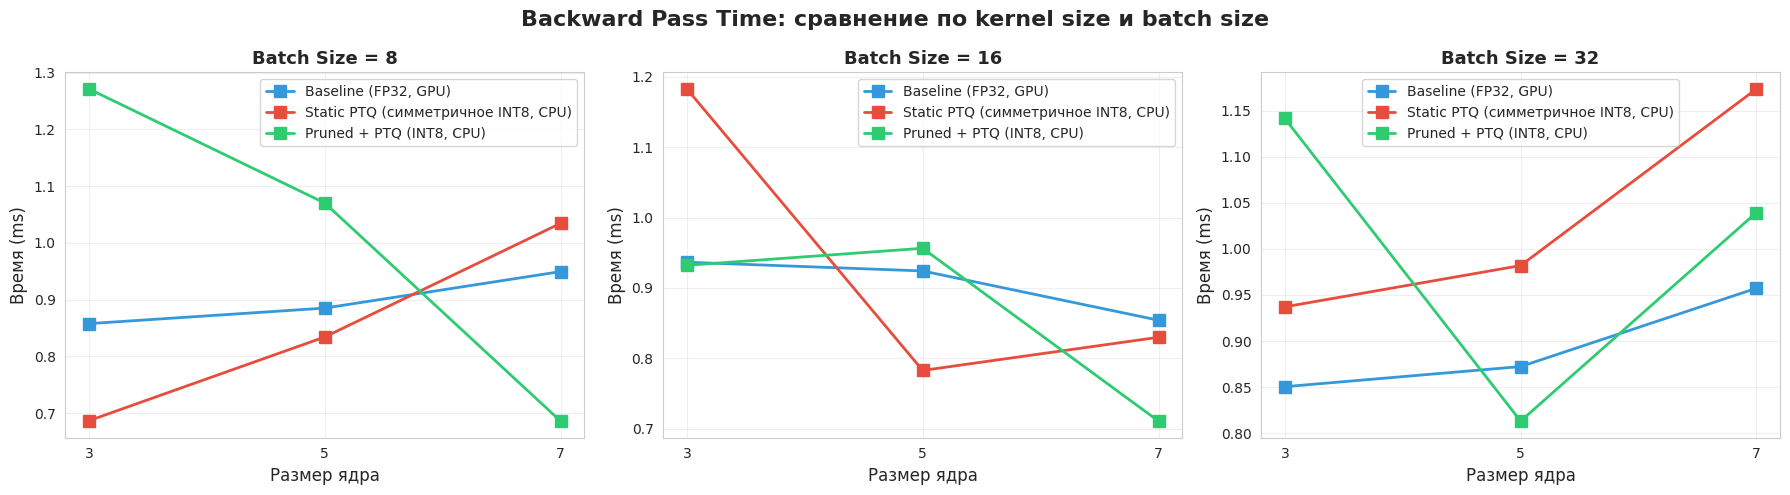

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Backward Pass Time: сравнение по kernel size и batch size', 
             fontsize=16, fontweight='bold')

for idx, batch_size in enumerate(BATCH_SIZES):
    ax = axes[idx]
    
    for opt_type in OPTIMIZATION_TYPES:
        data = df_results[
            (df_results['optimization_type'] == opt_type) & 
            (df_results['batch_size'] == batch_size)
        ]
        data_grouped = data.groupby('kernel_size')['backward_time_ms'].mean().reset_index()
        
        ax.plot(
            data_grouped['kernel_size'], 
            data_grouped['backward_time_ms'], 
            marker='s', 
            linewidth=2,
            markersize=8,
            label=labels[opt_type],
            color=colors[opt_type]
        )
    
    ax.set_xlabel('Размер ядра', fontsize=12)
    ax.set_ylabel('Время (ms)', fontsize=12)
    ax.set_title(f'Batch Size = {batch_size}', fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(KERNEL_SIZES)

plt.tight_layout()
plt.show()

### График 3: Лучшие метрики по ядру и батчу

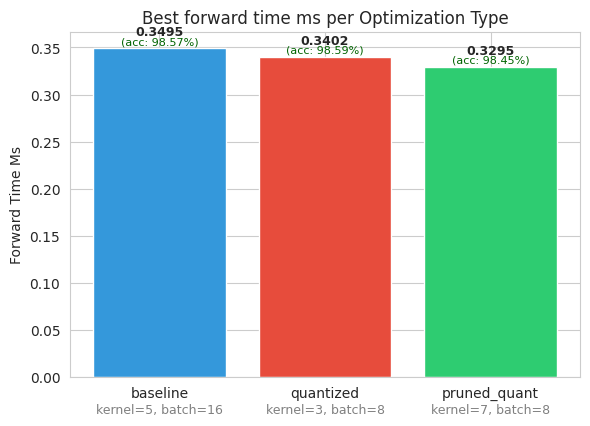

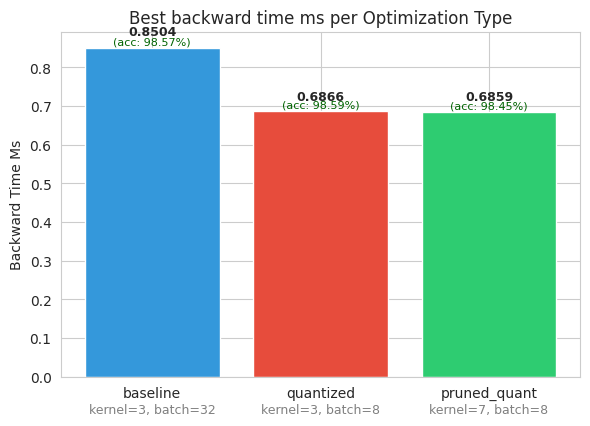

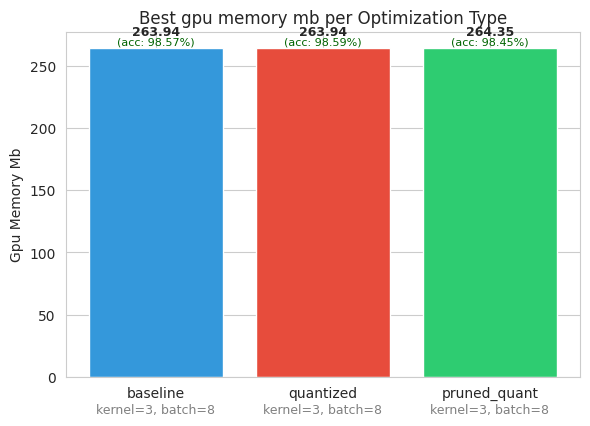

In [42]:
df = pd.DataFrame(df_results, columns=[
    "optimization_type", "kernel_size", "batch_size", "device", "test_accuracy",
    "forward_time_ms", "backward_time_ms", "total_time_ms", "gpu_memory_mb", "model_size_mb"
])

metrics = ["forward_time_ms", "backward_time_ms", "gpu_memory_mb"]
optim_types = ["baseline", "quantized", "pruned_quant"]

plt.rcParams.update({'font.size': 10})

for metric in metrics:
    values = []
    labels = []     
    accs = []  
    bar_colors = []

    for opt in optim_types:
        sub = df[df["optimization_type"] == opt]
        idx_min = sub[metric].idxmin()
        row = sub.loc[idx_min]

        values.append(row[metric])
        labels.append(f"kernel={int(row['kernel_size'])}, batch={int(row['batch_size'])}")
        accs.append(row["test_accuracy"])
        bar_colors.append(colors[opt])

    fig, ax = plt.subplots(figsize=(6, 4.5))
    bars = ax.bar(range(len(optim_types)), values, color=bar_colors)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        if "time" in metric:
            main_label = f"{values[i]:.4f}"
        else: 
            main_label = f"{values[i]:.2f}"
        
        acc_label = f"(acc: {accs[i]:.2f}%)"

        ax.text(bar.get_x() + bar.get_width() / 2, height + height * 0.03,
                main_label, ha='center', va='bottom', fontsize=9, fontweight='bold')
        ax.text(bar.get_x() + bar.get_width() / 2, height + height * 0.005,
                acc_label, ha='center', va='bottom', fontsize=8, color='darkgreen')

    ax.set_xticks(range(len(optim_types)))
    ax.set_xticklabels(optim_types)

    ymax = max(values)
    for i, label in enumerate(labels):
        ax.text(i, -ymax * 0.08, label, ha='center', va='top', fontsize=9, color='gray')

    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_title(f"Best {metric.replace('_', ' ')} per Optimization Type")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

In [43]:
avg_by_type = df_results.groupby('optimization_type').agg({
    'model_size_mb': 'mean',
    'test_accuracy': 'mean',
    'forward_time_ms': 'mean',
    'backward_time_ms': 'mean'
}).reset_index()

## Анализ результатов

In [53]:
# Сравнение Baseline с оптимизированными версиями
baseline_data = df_results[df_results['optimization_type'] == 'baseline']
quantized_data = df_results[df_results['optimization_type'] == 'quantized']
pruned_quant_data = df_results[df_results['optimization_type'] == 'pruned_quant']

print("Сравнение с Baseline (FP32, GPU):")

avg_baseline_forward = baseline_data['forward_time_ms'].mean()
avg_baseline_backward = baseline_data['backward_time_ms'].mean()
avg_baseline_memory = baseline_data['gpu_memory_mb'].mean()
avg_baseline_acc = baseline_data['test_accuracy'].mean()

avg_quant_forward = quantized_data['forward_time_ms'].mean()
avg_quant_backward = quantized_data['backward_time_ms'].mean()
avg_quant_acc = quantized_data['test_accuracy'].mean()

avg_pq_forward = pruned_quant_data['forward_time_ms'].mean()
avg_pq_backward = pruned_quant_data['backward_time_ms'].mean()
avg_pq_acc = pruned_quant_data['test_accuracy'].mean()

print()
print(f"Baseline:")
print(f"  Forward:  {avg_baseline_forward:.3f} ms")
print(f"  Backward: {avg_baseline_backward:.3f} ms")
print(f"  Memory:   {avg_baseline_memory:.2f} MB")
print(f"  Accuracy: {avg_baseline_acc:.2f}%")

print()
print(f"Static PTQ:")
print(f"  Forward:  {avg_quant_forward:.3f} ms ")
print(f"  Backward: N/A (квантованные модели только inference)")
print(f"  Accuracy: {avg_quant_acc:.2f}% (изменение: {avg_quant_acc - avg_baseline_acc:+.2f}%)")
print(f"  Model size: {avg_by_type[avg_by_type['optimization_type']=='quantized']['model_size_mb'].values[0]:.3f} MB")

print()
print(f"Pruned + Static PTQ:")
print(f"  Forward:  {avg_pq_forward:.3f} ms")
print(f"  Backward: N/A (квантованные модели только inference)")
print(f"  Accuracy: {avg_pq_acc:.2f}% (изменение: {avg_pq_acc - avg_baseline_acc:+.2f}%)")
print(f"  Model size: {avg_by_type[avg_by_type['optimization_type']=='pruned_quant']['model_size_mb'].values[0]:.3f} MB")

print()
print("Влияние batch size:")
print("─" * 80)
for batch_size in BATCH_SIZES:
    data = df_results[df_results['batch_size'] == batch_size]
    avg_time = data['total_time_ms'].mean()
    print(f"  Batch {batch_size}: среднее общее время = {avg_time:.3f} ms")

print()
print("Влияние kernel size:")
print("─" * 80)
for kernel_size in KERNEL_SIZES:
    data = df_results[df_results['kernel_size'] == kernel_size]
    avg_time = data['total_time_ms'].mean()
    print(f"  Ядро {kernel_size}×{kernel_size}: среднее общее время = {avg_time:.3f} ms")

Сравнение с Baseline (FP32, GPU):

Baseline:
  Forward:  0.440 ms
  Backward: 0.899 ms
  Memory:   264.77 MB
  Accuracy: 98.57%

Static PTQ:
  Forward:  0.418 ms 
  Backward: N/A (квантованные модели только inference)
  Accuracy: 98.59% (изменение: +0.02%)
  Model size: 0.415 MB

Pruned + Static PTQ:
  Forward:  0.434 ms
  Backward: N/A (квантованные модели только inference)
  Accuracy: 98.45% (изменение: -0.12%)
  Model size: 0.415 MB

Влияние batch size:
────────────────────────────────────────────────────────────────────────────────
  Batch 8: среднее общее время = 1.324 ms
  Batch 16: среднее общее время = 1.305 ms
  Batch 32: среднее общее время = 1.459 ms

Влияние kernel size:
────────────────────────────────────────────────────────────────────────────────
  Ядро 3×3: среднее общее время = 1.393 ms
  Ядро 5×5: среднее общее время = 1.306 ms
  Ядро 7×7: среднее общее время = 1.389 ms
